# On the Eigenvector Bias of Fourier Feature Networks: From Regression to Solving Multi-Scale PDEs with Physics-Informed Neural Networks

Experimentos relacionados con el paper "On the Eigenvector Bias of Fourier Feature Networks: From Regression to Solving Multi-Scale PDEs with Physics-Informed Neural Networks", Sifan Wang and Hanwen Wang and Paris Perdikaris.

In [1]:
# Librerias
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn        
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time

import plotly.graph_objects as go

# Regresión

Resolver el problema de regresión para la siguiente función

In [2]:
def u(x, a, b):
    return np.sin(2 * np.pi * x) +  b * np.sin(a * np.pi * x)

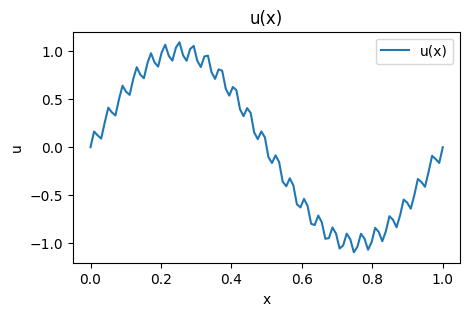

In [5]:
# Training data on u(x) 
N_u = 100
X_u = torch.linspace(0.0, 1.0,  N_u)[:, None]

a = 50
b = 0.1
u_obj = u(X_u, a, b)


# Gráfica
plt.figure(figsize=(5, 3))
plt.plot(X_u, u_obj, label='u(x)')  
plt.title('u(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()


## Experimento 1
Aproximar una Ned neuronal a la función objetivo

In [6]:
class NN(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, num_layers = 5, output_size = 1):
        super(NN, self).__init__()
        
        # Red Neuronal sin embeding
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            self.hidden_layers.add_module('linear'+str(l), nn.Linear(input_size, hidden_size))
            self.hidden_layers.add_module('tanh'+str(l), nn.Tanh()) 
            input_size = hidden_size
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        self.loss_history = {'Loss': []}

    def forward(self, x):
        return self.hidden_layers(x)  
    
    def loss(self, x, y):
        return nn.MSELoss()(self.forward(x), y)
    
    def train(self, x, y, epochs = 10000, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = self.loss(x, y)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            if epoch % 1000 == 0:
                print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch, epochs, loss.item()))
        print('Tiempo de entrenamiento: ', time.time() - start)

In [7]:
Red_1 = NN()

In [11]:
X_u.requires_grad = True
Red_1.train(X_u, u_obj, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [0/10000], Loss: 0.004955
Epoch [1000/10000], Loss: 0.004922
Epoch [2000/10000], Loss: 0.004921
Epoch [3000/10000], Loss: 0.004933
Epoch [4000/10000], Loss: 0.005320
Epoch [5000/10000], Loss: 0.004920
Epoch [6000/10000], Loss: 0.005262
Epoch [7000/10000], Loss: 0.004925
Epoch [8000/10000], Loss: 0.004931
Epoch [9000/10000], Loss: 0.004949
Tiempo de entrenamiento:  8.271096229553223


## Resultados

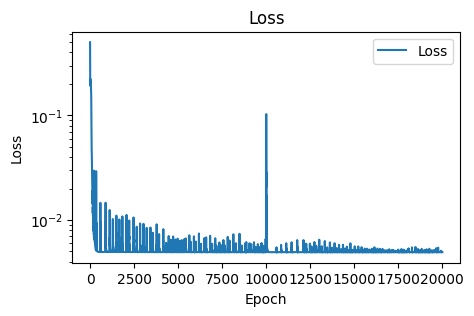

In [12]:
# Gráfica Loss
plt.figure(figsize=(5, 3))
plt.plot(Red_1.loss_history['Loss'], label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

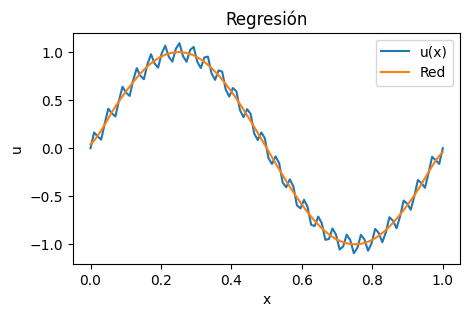

In [13]:
# Grafica Regresión
plt.figure(figsize=(5, 3))
plt.plot(X_u.detach().numpy(), u_obj, label='u(x)')
plt.plot(X_u.detach().numpy(), Red_1(X_u).detach().numpy(), label='Red')
plt.title('Regresión')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

## Experimento 2
Aproximar una Ned neuronal a la función objetivo usando embeding de Fourier

In [14]:
class NN_FE(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=5, output_size=1, fourier_features_size=100, sigma=10.0):
        super(NN_FE, self).__init__()
        
        # Generar frecuencias aleatorias para Fourier Feature Embedding
        self.B = sigma * torch.randn(input_size, fourier_features_size)

        # Definir las capas ocultas de la red neuronal
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                # La entrada debe tener el tamaño de las características de Fourier (2 * fourier_features_size)
                self.hidden_layers.add_module('linear' + str(l), nn.Linear(2 * fourier_features_size, hidden_size))
            else:
                self.hidden_layers.add_module('linear' + str(l), nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.add_module('tanh' + str(l), nn.Tanh())
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        # Historial de pérdidas
        self.loss_history = {'Loss': []}
    
    # Función de Fourier Feature Embedding
    def fourier_features(self, x):
        # Aplicar B * x para generar las características sinusoidales
        projection = torch.matmul(x, self.B)
        return torch.cat([torch.sin(projection), torch.cos(projection)], dim=-1)

    def forward(self, x):
        # Aplicar Fourier Feature Embedding a la entrada
        x = self.fourier_features(x)
        return self.hidden_layers(x)
    
    def loss(self, x, y):
        return nn.MSELoss()(self.forward(x), y)
    
    def train(self, x, y, epochs = 10000, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = self.loss(x, y)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            if epoch % 1000 == 0:
                print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch, epochs, loss.item()))
        print('Tiempo de entrenamiento: ', time.time() - start)

In [15]:
Red_2 = NN_FE()

In [16]:
X_u.requires_grad = True
Red_2.train(X_u, u_obj, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [0/10000], Loss: 0.506826
Epoch [1000/10000], Loss: 0.004918
Epoch [2000/10000], Loss: 0.004903
Epoch [3000/10000], Loss: 0.002615
Epoch [4000/10000], Loss: 0.000166
Epoch [5000/10000], Loss: 0.000031
Epoch [6000/10000], Loss: 0.000206
Epoch [7000/10000], Loss: 0.000011
Epoch [8000/10000], Loss: 0.000012
Epoch [9000/10000], Loss: 0.000071
Tiempo de entrenamiento:  11.257843971252441


## Resultados

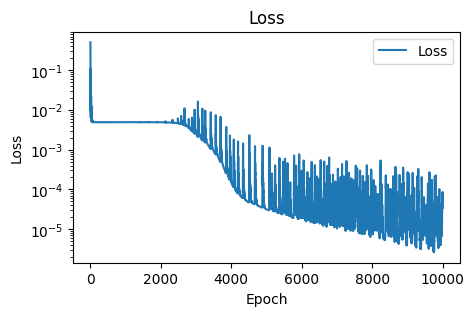

In [17]:
# Gráfica Loss
plt.figure(figsize=(5, 3))
plt.plot(Red_2.loss_history['Loss'], label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

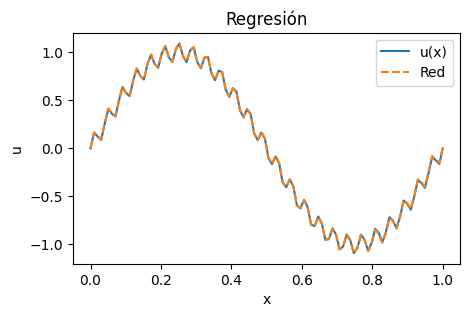

In [19]:
# Grafica Regresión
plt.figure(figsize=(5, 3))
plt.plot(X_u.detach().numpy(), u_obj, label='u(x)')
plt.plot(X_u.detach().numpy(), Red_2(X_u).detach().numpy(), '--', label='Red')
plt.title('Regresión')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

**Observación:** El Embeding de Fourier permite que la red aprenda la función objetivo.

# PINNs

Considere la ecuación de Poisson 1D 

$$ \Delta u(x) = f(x), \hspace{1cm} x \in (0,1) $$
sujeto a las condiciones $u(0)=u(1)=0$. Considere la solución $u(x)=\sin(2\pi x) + 0.1 \sin(50 \pi x)$, entonces $f(x)= -4\pi^2 \sin (2\pi x ) - 250\pi^2 \sin(50 \pi x)$. Resolvemos el problema anterior usando el enfoque pinns.

## Experimento 3
Resolver la ecuación diferencial con una red neuronal sin embeding de Fourier

In [31]:
class NN_PINN(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=5, output_size=1):
        super(NN_PINN, self).__init__()
        
        # Definir las capas ocultas de la red neuronal
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                # La entrada debe tener el tamaño de las características de Fourier (2 * fourier_features_size)
                self.hidden_layers.add_module('linear' + str(l), nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.add_module('linear' + str(l), nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.add_module('tanh' + str(l), nn.Tanh())
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        # Historial de pérdidas
        self.loss_history = {'Loss': [],
                             'Loss_edo': [],
                             'Loss_bc': []}

    def forward(self, x):
        return self.hidden_layers(x)
    
    def loss_edo(self, x):
        u = self.forward(x)
        u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        phi = u_xx - ( - 4 * torch.pi ** 2 * torch.sin(2 * torch.pi * x) - 250 * torch.pi ** 2 * torch.sin(50 * torch.pi * x))
        loss = torch.mean(phi**2)
        return loss
    
    def loss_bc(self, x0, y0):
        return nn.MSELoss()(self.forward(x0), y0)
    
    def compute_loss(self, x, x0, y0):
        loss_edo = self.loss_edo(x)
        loss_bc = self.loss_bc(x0, y0)
        loss = loss_edo + loss_bc
        return loss, loss_edo, loss_bc
    
    def train(self, x, x0, y0, epochs = 10000, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss, loss_edo, loss_bc = self.compute_loss(x, x0, y0)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            self.loss_history['Loss_edo'].append(loss_edo.item())
            self.loss_history['Loss_bc'].append(loss_bc.item())
            if epoch % 1000 == 0:
                print('Epoch [{}/{}], Loss: {:.6f}, Loss_edo: {:.6f}, Loss_bc: {:.6f}'.format(epoch, epochs, loss.item(), loss_edo.item(), loss_bc.item()))
        print('Tiempo de entrenamiento: ', time.time() - start)

In [32]:
Red_3 = NN_PINN()

In [156]:
X_u.requires_grad = True
X_bc = torch.tensor([0.0, 1.0])[:, None]
u_bc = u(X_bc, a, b)

In [41]:
Red_3.train(X_u, X_bc, u_bc, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [0/10000], Loss: 3014373.500000, Loss_edo: 3014373.500000, Loss_bc: 0.017144
Epoch [1000/10000], Loss: 2780188.000000, Loss_edo: 2780187.500000, Loss_bc: 0.464881
Epoch [2000/10000], Loss: 2436002.500000, Loss_edo: 2436002.500000, Loss_bc: 0.104625
Epoch [3000/10000], Loss: 1519769.500000, Loss_edo: 1519754.250000, Loss_bc: 15.303575
Epoch [4000/10000], Loss: 542647.437500, Loss_edo: 542638.625000, Loss_bc: 8.815404
Epoch [5000/10000], Loss: 36932.304688, Loss_edo: 36928.941406, Loss_bc: 3.363603
Epoch [6000/10000], Loss: 36762.089844, Loss_edo: 36759.269531, Loss_bc: 2.821041
Epoch [7000/10000], Loss: 42408.910156, Loss_edo: 42405.871094, Loss_bc: 3.040873
Epoch [8000/10000], Loss: 44026.070312, Loss_edo: 44024.570312, Loss_bc: 1.499568
Epoch [9000/10000], Loss: 4521.517090, Loss_edo: 4519.507324, Loss_bc: 2.009755
Tiempo de entrenamiento:  24.20434808731079


## Resultados

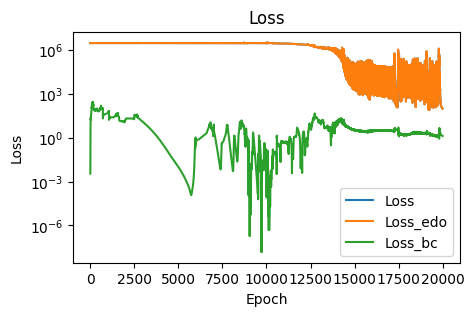

In [43]:
# Gráfica Loss
plt.figure(figsize=(5, 3))
plt.plot(Red_3.loss_history['Loss'], label='Loss')
plt.plot(Red_3.loss_history['Loss_edo'], label='Loss_edo')
plt.plot(Red_3.loss_history['Loss_bc'], label='Loss_bc')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

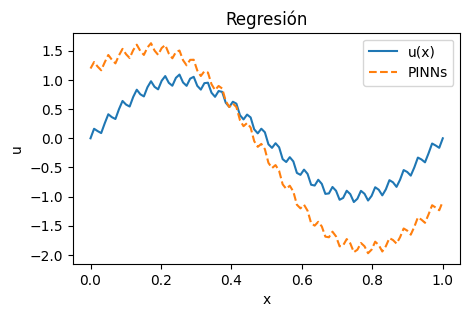

In [42]:
# Grafica Solución PINNs
plt.figure(figsize=(5, 3))
plt.plot(X_u.detach().numpy(), u_obj, label='u(x)')
plt.plot(X_u.detach().numpy(), Red_3(X_u).detach().numpy(), '--', label='PINNs')
plt.title('PINNs')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

## Experimento 4
Resolver la ecuación diferencial con una red neuronal con embeding de Fourier

In [166]:
class NN_PINN_FE(nn.Module):
    def __init__(self, input_size=1, hidden_size=200, num_layers=5, output_size=1, fourier_features_size=100, sigma=20.0):
        super(NN_PINN_FE, self).__init__()
        
        # Generar frecuencias aleatorias para Fourier Feature Embedding
        self.B = sigma * torch.randn(input_size, fourier_features_size)
        #self.B = nn.Parameter(sigma * torch.randn(input_size, fourier_features_size), trainable=False)

        # Definir las capas ocultas de la red neuronal
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                # La entrada debe tener el tamaño de las características de Fourier (2 * fourier_features_size)
                self.hidden_layers.add_module('linear' + str(l), nn.Linear(2 * fourier_features_size, hidden_size))
            else:
                self.hidden_layers.add_module('linear' + str(l), nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.add_module('tanh' + str(l), nn.Tanh())
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        # Historial de pérdidas
        self.loss_history = {'Loss': [],
                             'Loss_edo': [],
                             'Loss_bc': []}

    # Función de Fourier Feature Embedding
    def fourier_features(self, x):
        # Aplicar B * x para generar las características sinusoidales
        projection = torch.matmul(x, self.B)
        return torch.cat([torch.cos(projection), torch.sin(projection)], dim=-1)

    def forward(self, x):
        # Aplicar Fourier Feature Embedding a la entrada
        x = self.fourier_features(x)
        return self.hidden_layers(x)
    
    def loss_edo(self, x):
        u = self.forward(x)
        u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        phi = u_xx - ( - 4 * torch.pi ** 2 * torch.sin(2 * torch.pi * x) - 250 * torch.pi ** 2 * torch.sin(50 * torch.pi * x))
        loss = nn.MSELoss()(phi, torch.zeros_like(phi))
        return loss
    
    def loss_bc(self, x0, y0):
        return nn.MSELoss()(self.forward(x0), y0)
    
    def compute_loss(self, x, x0, y0):
        loss_edo = self.loss_edo(x)
        loss_bc = self.loss_bc(x0, y0)
        loss = loss_edo + loss_bc
        return loss, loss_edo, loss_bc
    
    def train(self, x, x0, y0, epochs = 10000, lr = 1e-3):
        
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss, loss_edo, loss_bc = self.compute_loss(x, x0, y0)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            self.loss_history['Loss_edo'].append(loss_edo.item())
            self.loss_history['Loss_bc'].append(loss_bc.item())
            if epoch % 1000 == 0:
                print('Epoch [{}/{}], Loss: {:.6f}, Loss_edo: {:.6f}, Loss_bc: {:.6f}'.format(epoch, epochs, loss.item(), loss_edo.item(), loss_bc.item()))
        print('Tiempo de entrenamiento: ', time.time() - start)

        print("Starting optimization with L-BFGS")

        # L-BFGS Optimizer
        def closure():
            optimizer.zero_grad()
            loss, loss_edo, loss_bc = self.compute_loss(x, x0, y0)
            loss.backward()
            self.loss_history['Loss'].append(loss.item())
            self.loss_history['Loss_edo'].append(loss_edo.item())
            self.loss_history['Loss_bc'].append(loss_bc.item())
            return loss

        optimizer = torch.optim.LBFGS(self.parameters(), lr=0.1,
                              max_iter = 10000,
                              max_eval = None,
                              tolerance_grad = 1e-11,
                              tolerance_change = 1e-11,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')

        # Optimización
        start_time = time.time()
        optimizer.step(closure)  # Directamente usando self.closure
        elapsed = time.time() - start_time
        print('Finish: Training time L-BFGS: %.2f' % elapsed)
        

In [167]:
Red_4 = NN_PINN_FE()

In [172]:
N_u = 300
X_u = torch.linspace(0.0, 1.0,  N_u)[:, None]
X_u.requires_grad = True

# Borde
X_bc = torch.tensor([0.0, 1.0])[:, None]
#u_bc = u(X_bc, a, b)


In [169]:
Red_4.train(X_u, X_bc, u_bc, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [0/10000], Loss: 3035610.000000, Loss_edo: 3035610.000000, Loss_bc: 0.002552
Epoch [1000/10000], Loss: 83.548546, Loss_edo: 80.315742, Loss_bc: 3.232807
Epoch [2000/10000], Loss: 38.858624, Loss_edo: 37.561558, Loss_bc: 1.297067
Epoch [3000/10000], Loss: 34.667896, Loss_edo: 34.351353, Loss_bc: 0.316545
Epoch [4000/10000], Loss: 327.124390, Loss_edo: 327.121521, Loss_bc: 0.002876
Epoch [5000/10000], Loss: 21.256855, Loss_edo: 21.256567, Loss_bc: 0.000288
Epoch [6000/10000], Loss: 40.391769, Loss_edo: 40.349915, Loss_bc: 0.041854
Epoch [7000/10000], Loss: 1465.900391, Loss_edo: 1465.838867, Loss_bc: 0.061542
Epoch [8000/10000], Loss: 1412.316650, Loss_edo: 1412.244995, Loss_bc: 0.071618
Epoch [9000/10000], Loss: 104.353706, Loss_edo: 104.310432, Loss_bc: 0.043274
Tiempo de entrenamiento:  141.6086368560791
Starting optimization with L-BFGS
Finish: Training time L-BFGS: 71.55


## Resultados

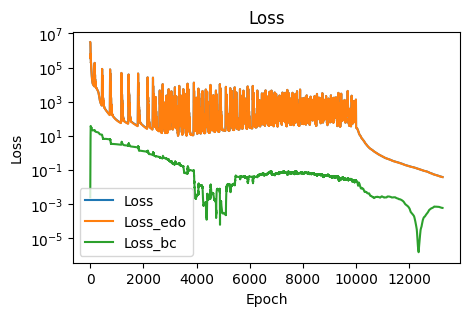

In [170]:
# Gráfica Loss
plt.figure(figsize=(5, 3))
plt.plot(Red_4.loss_history['Loss'], label='Loss')
plt.plot(Red_4.loss_history['Loss_edo'], label='Loss_edo')
plt.plot(Red_4.loss_history['Loss_bc'], label='Loss_bc')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

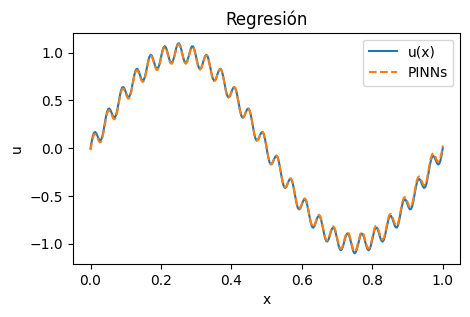

In [171]:
# Grafica Solución PINN
a = 50
b = 0.1
X_u.requires_grad = False

# Función Objetivo
a = 50
b = 0.1
u_obj = u(X_u, a, b)


#u_obj = u(X_u, a, b)

plt.figure(figsize=(5, 3))
plt.plot(X_u.detach().numpy(), u_obj, label='u(x)')
plt.plot(X_u.detach().numpy(), Red_4(X_u).detach().numpy(), '--', label='PINNs')
plt.title('Regresión')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()